## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm # progress bar


## Get dataset and DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)

In [3]:
# train_X = trainset.data
# train_y = trainset.targets
# test_X = testset.data
# test_y = testset.targets

# plt.imshow(train_X[0])
# plt.title(f"Label is: {train_y[0]}")
# plt.show()

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


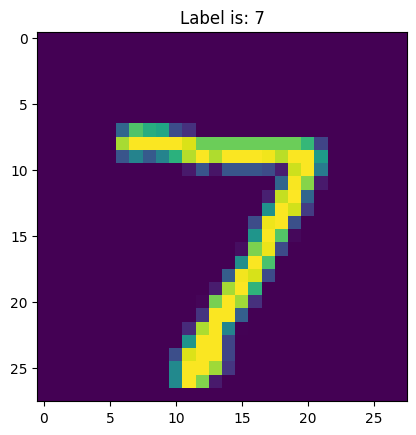

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    plt.imshow(X[0][0])
    
    plt.title(f"Label is: {y[0]}")
    plt.show()
    
    break

## Model

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Model

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size = 28*28, num_classes = 10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.nn_forward_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.nn_forward_stack(x)
        return logits

model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn_forward_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Training

Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

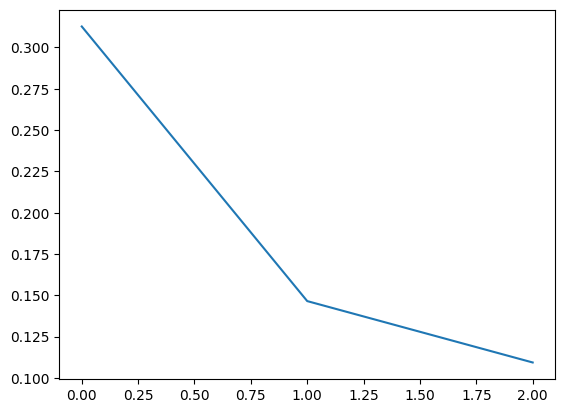

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
train_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device) # Xs, ys
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

plt.plot(train_losses)
plt.show()

## Testing


In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval() 

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1) 
            num_correct += (predictions == y).sum()  
            num_samples += predictions.size(0)  

        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    
    model.train()  # Set the model back to training mode

check_accuracy(train_dataloader, model)
check_accuracy(test_dataloader, model)


Got 57998/60000 with accuracy 96.66%
Got 9623/10000 with accuracy 96.23%


Model thinks it is: 9


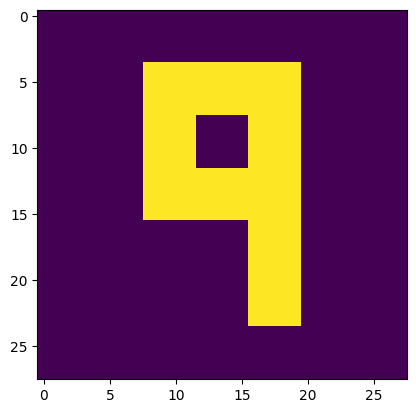

In [13]:
m = [[0,0,0,0,0,0,0],
     [0,0,1,1,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
input_tensor = torch.Tensor(m).reshape(1,1, len(m), len(m[0]))
resized_tensor = nn.functional.interpolate(input_tensor, size=(28, 28))

y_pred = model(resized_tensor)
guess = torch.argmax(y_pred)
print(f"Model thinks it is: {guess}")

plt.imshow(resized_tensor[0][0])
plt.show()